In [11]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [12]:
from IPython.core.display import display, HTML
#display(HTML('<style>.container {width:100% !important;} <\style>'))

In [13]:
from lsi import LinearAimAssister, LinearEigenInterpolator, Dp54Linear
#from cy import SplineAimAssister, SplineEigenInterpolator #<= Krever Fortran-Python-kobling

In [14]:
from auxiliarypointstuff import cy_compute_pos_aim, cy_cross_product, \
                                cy_in_plane, cy_orthogonal_component, \
                                cy_parallel_component, cy_normalize, \
                                cy_norm2, cy_min

In [15]:
from ndcurvebsplineinterp import NDCurveBSplineInterpolator

In [16]:
import sys
sys.path.insert(0,'../..') # Sett inn det som trengs for at numerical_integrators
                           # blir tilgjengelig i path

In [17]:
from numerical_integrators.singlestep import rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkdp54,rkdp87

In [18]:
import multiprocessing as mp
import numpy as np
from numba import njit
from scipy.interpolate import splprep as scp_splprep,\
                              splev as scp_splev
import time

In [19]:
#np.linalg.norm(v)

In [20]:
import matplotlib as mpl
mpl.use("pgf")

#################################################
##### Fjern kommentarer for bonus-stilpoeng #####
#################################################

# Custom matplotlib config (fonts etc)

## TeX preamble
#pgf_with_pdflatex = {
#    "font.family": "serif",
#    "text.usetex": True,
#    "text.latex.unicode": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",
#         r"\usepackage[T1]{fontenc}",
#         r"\usepackage[]{libertine}"
#         r"\usepackage[libertine]{newtxmath}"
#         ]
#}
#mpl.rcParams.update(pgf_with_pdflatex)


#mpl.rcParams['font.family'] = 'Libertine'

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

#import matplotlib.font_manager as fm
#prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

from matplotlib import pyplot as plt
#plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [21]:
def f(t,x,A=1,B=1,C=1):
    """
    param: t -- Time
    param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                Shape: (12,nx,ny,nz)
    
    return: Twelve-component array, containing the (component-wise) right hand side of the
            coupled equation of variations
            Shape: (12,nx,ny,nz)
    """
    ret     = np.empty(x.shape)
    ret[0]  = A*np.sin(x[2]) + C*np.cos(x[1])                # x-component of velocity field
    ret[1]  = B*np.sin(x[0]) + A*np.cos(x[2])                # y-component of velocity field
    ret[2]  = C*np.sin(x[1]) + B*np.cos(x[0])                # z-component of velocity field
    ret[3]  = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]     # The remaining (coupled) entries 
    ret[4]  = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]    # constitute the RHS of the 
    ret[5]  = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]    # variational ODE for the 
    ret[6]  = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]     # flow map Jacobian
    ret[7]  = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8]  = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9]  = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,func,integ,nproc=4):
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc)
    u,s,v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (np.ascontiguousarray(lm1), np.ascontiguousarray(lm2), np.ascontiguousarray(lm3)), \
            (np.ascontiguousarray(xi1), np.ascontiguousarray(xi2), np.ascontiguousarray(xi3))
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j]))
          for j in range(nproc)]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [22]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [23]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:

(lm1,lm2,lm3),(xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,f,flowmap_integrator)


In [24]:
# Compute Hessian efficiently by making use of NumPy's gradient function
def compute_hessian_lm(lm,dx,dy,dz):
    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
    for k, grad_k in enumerate(grad):
        # Iterate over the number of dimensions
        # Apply gradient operator to each component of the first derivative
        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[...,k,l] = grad_kl
    return hessian

In [25]:
# Compute AB subdomain
def find_points_in_ab(hess_lm3,lm3,lm2,xi3):
    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
    return np.logical_and(mask_a,mask_b)

In [26]:
# Currently not used - kept for future reference wrt parameters etc
hlm3 = compute_hessian_lm(lm3,x,y,z)
mask_ab = find_points_in_ab(hlm3,lm3,lm2,xi3)

In [27]:
linear_itp = True # <= Må være True så lenge Fortran-Python-kobling ikke er på plass

In [28]:
if linear_itp:
    xi1_itp = LinearEigenInterpolator(x,y,z,xi1)
    xi2_itp = LinearEigenInterpolator(x,y,z,xi2)
    xi3_itp = LinearEigenInterpolator(x,y,z,xi3)
    direction_generator = LinearAimAssister(xi3_itp)
    dp54_p = Dp54Linear()
else:
    xi1_itp = SplineEigenInterpolator(x,y,z,xi1,3,3,3)
    xi2_itp = SplineEigenInterpolator(x,y,z,xi2,3,3,3)
    xi3_itp = SplineEigenInterpolator(x,y,z,xi3,3,3,3)
    direction_generator = SplineAimAssister(xi3_itp)

In [29]:
# Spesiell lineærinterpolasjon gjøres nå på Cython-nivå, beholder koden i denne cellen som ref

#class LinearSpecialInterpolator:
#    """
#    LinearSpecialInterpolator(xi,x,y,z)
#        
#    A collection of methods to perform linear interpolation with direction correction,
#    of three-dimensional strain eigenvectors.
#        
#    param: xi -- NumPy array of shape (len(x),len(y),len(z),3), containing the eigenvectors xi
#                 given at the grid points spanned by x, y and z
#    param: x  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: y  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: z  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    
#    ******************************************************************************************
#    
#    Methods defined here:
#    
#    LinearSpecialInterpolator.__call__(x)
#    
#    Performs the aforementioned special linear interpolation of the eigenvector xi at
#    the point x.
#    
#    param: x -- Three-component NumPy array, containing the coordinates at which a linear
#                special interpolation of xi is sought; (x,y,z).
#        
#    return: Three-component NumPy array, containing the normalized linearly interpolated
#            xi value at the point x.
#    """
#    def __init__(self,xi,x,y,z):
#        self.xi = xi
#        self.nx = xi.shape[0]-1
#        self.ny = xi.shape[1]-1
#        self.nz = xi.shape[2]-1
#        self.dx = x[1]-x[0]
#        self.dy = y[1]-y[0]
#        self.dz = z[1]-z[0]
#        self.x_min = x[0]
#        self.x_max = x[self.nx-1]
#        self.y_min = y[0]
#        self.y_max = y[self.ny-1]
#        self.z_min = z[0]
#        self.z_max = z[self.nz-1]
#        self.version = '0.1' # To keep track of changes as we go along
#    
#    def __call__(self,x):
#        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
#        cubevecs = [self.xi[ix,iy,iz],
#                    self.xi[ixp1,iy,iz],
#                    self.xi[ix,iyp1,iz],
#                    self.xi[ixp1,iyp1,iz],
#                    self.xi[ix,iy,izp1],
#                    self.xi[ixp1,iy,izp1],
#                    self.xi[ix,iyp1,izp1],
#                    self.xi[ixp1,iyp1,izp1]]
#        # Flip vectors 180 degrees if they are rotated more than 90 degrees with regards to
#        # an arbitrary reference point within the interpolation voxel
#        for i in range(8):
#            if cubevecs[0].dot(cubevecs[i]) < 0:
#                cubevecs[i] = -cubevecs[i]
#        
#        # 
#        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
#    
#    def _compute_indices_and_weights(self,x,y,z):
#        """
#        param: x -- x-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: y -- y-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: z -- z-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#                    
#        return: x    -- Normalized relative coordinate within the interpolation voxel
#        return: ix   -- Index indicating the corners of the interpolation voxel
#        return: ixp1 -- Index indicating the corners of the interpolation voxel
#        return: y    -- Normalized relative coordinate within the interpolation voxel
 #       return: iy   -- Index indicating the corners of the interpolation voxel
 #       return: iyp1 -- Index indicating the corners of the interpolation voxel
 #       return: z    -- Normalized relative coordinate within the interpolation voxel
 #       return: iz   -- Index indicating the corners of the interpolation voxel
 #       return: izp1 -- Index indicating the corners of the interpolation voxel
 #       """
 #       x = np.fmod((x-self.x_min)/self.dx,self.nx)
 #       y = np.fmod((y-self.y_min)/self.dy,self.ny)
 #       z = np.fmod((z-self.z_min)/self.dz,self.nz)
 #       
 #       while x < 0:
 #           x += self.nx
 #       while y < 0:
 #           y += self.ny
 ##       while z < 0:
 #           z += self.nz
 #           
 #       ix = np.floor(x).astype(int)
 #       iy = np.floor(y).astype(int)
 #       iz = np.floor(z).astype(int)
 #       
 #       x -= ix
 #       y -= iy
 #       z -= iz
 #       
 #       ixp1 = int((ix+1)%self.nx)
 #       iyp1 = int((iy+1)%self.ny)
 #       izp1 = int((iz+1)%self.nz)
 #       
 #       return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
 #   
 #   @staticmethod
 #   def _normalized_weighted_sum(cubevecs,x,y,z):
 #       """
 #       param: cubevecs -- List of xi vectors defined at the corners of the interpolation voxel
 #       param:        x -- Normalized relative coordinate within the interpolation voxel
 #       param:        y -- Normalized relative coordinate within the interpolation voxel
 #       param:        z -- Normalized relative coordinate within the interpolation voxel
 #       
 #       return:     vec -- Normalized linearly interpolated xi vector 
 #       """
 #       vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
 #               +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
 #       return vec/np.linalg.norm(vec)

In [30]:
# Sikting gjøres nå på Cython-nivå. Beholder koden i denne cellen som ref.

#class AimAssister:
#    """
#    AimAssister(target,xi1,xi2)
#    
#    A collection of methods to assist with the process of computing the best
#    targetting aproximation of a point based on linear combinations of
#    the local eigenvectors xi1 and xi2.
#        
#    param: target -- NumPy array containing the coordinates of the point we're aiming for
#    param:    xi1 -- A LinearSpecialInterpolator instance, calibrated for xi1
#    param:    xi2 -- A LinearSpecialInterpolator instance, calibrated for xi2
#    
#    ****************************************************************************************
#    
#    Methods defined here:
#    
#    AimAssister.__call__(t,x)
#    
#    param: t -- Dummy variable, required when using an adaptive stepsize integrator to track
#                arclength (i.e., pseudotime)
#    param: x -- The current point, at which one wants to obtain the component of the
#                vector separating *this* and the target, within the plane spanned
#                by the local xi1 and xi2 vectors
#                    
#    return: Normalized 'best-estimate' vector component in the plane spanned by xi1 and xi2
#    """
#    def __init__(self, target, xi1, xi2):
#        self.target = target
#        self.xi1 = xi1
#        self.xi2 = xi2
#        self.a1 = False
#        self.a2 = False
#        self.fixed = False
#    
#    def __call__(self, t, x):
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        
#        if not self.fixed:
#            
#
#            r = self.target-x
#            r /= np.linalg.norm(r)
#
#            a1 = np.dot(xi1, r)
#            a2 = np.dot(xi2, r)
#        else:
#            a1 = self.a1
#            a2 = self.a2
#        
#        vec = a1*xi1 + a2*xi2
#        #print('a1 =', a1, 'a2 =', a2)
#        return vec/np.linalg.norm(vec)
#    
#    def fix(self,x):
#        r = self.target-x
#        r /= np.linalg.norm(r)
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        self.a1 = np.dot(xi1, r)
#        self.a2 = np.dot(xi2, r)
#        self.fixed = True

In [31]:
# Dummy classes, which replace the LinearSpecialInterpolator instances
# in 'AimAssister' when a spherical shell is considered
class Evec1:
    def __call__(self,x):
        vec = np.array([x[0]*x[2],x[1]*x[2],-x[1]**2-x[0]**2])
        return vec/np.linalg.norm(vec)
class Evec2:
    def __call__(self,x):
        vec=np.array([x[1],-x[0],0])
        return vec/np.linalg.norm(vec)    

In [32]:
##### Manifold class #####

class Manifold:
    """
    Manifold(init_pos,min_u_step,max_u_step,dist,dist_tol,min_ang,max_ang,
                      min_dist_ang,max_dist_ang,min_sep,max_sep)
             
    A wrapper class for a set of the geodesic level sets which
    constitute an invariant manifold.
    
    param:     init_pos -- NumPy array containing the initial position (x,y,z)
                           from which the manifold is constructed
    param:    dom_bound -- Lower and upper boundaries of domain in which the
                           manifold may be developed.
                           Form: [x_low, x_up, y_low, y_up, z_low, z_up]
    param: max_geo_dist -- Maximum geodesic distance. Used to terminate
                           development of manifold
    param:   min_u_step -- Minimum step along the u abscissa (for local
                           evaluation of b-spline interpolations of 
                           any given level set)
    param:   max_u_step -- Minimum step along the u abscissa (for local
                           evaluation of b-spline interpolations of 
                           any given level set)
    param:         dist -- The (initial) radial distance from each
                           point in a given level set, to the 
                           'radially connected' point in the
                           construction of the next level set
    param:     dist_tol -- Numerical tolerance parameter for the
                           above. 0 <= dist_tol <= 1
    param:    plane_tol -- Numerical tolerance parameter for the acceptance of
                           points as members of a plane
    param:      tan_tol -- Tolerance for angular offset between consecutive
                           tangential (half-plane defining) vectors
                           (used in normalized dot product)
    param:      min_ang -- Minimal radial angular deviation between
                           consecutive constructed level sets,
                           under which 'dist' is increased
                           before the _next_ level set is 
                           constructed
    param:      max_ang -- Maximal radial angular deviation between
                           consecutive constructed level sets,
                           over which 'dist' is decreased,
                           the most recent attempt at creating
                           a level set is discarded, and
                           attempted anew with decreased 'dist'
    param: min_dist_ang -- Minimal product of 'dist' and
                           radial angular deviation between
                           consecutive constructed level sets,
                           under which 'dist' is increased
                           before the _next_ level set is
                           constructed
    param: max_dist_ang -- Maximal product of 'dist' and
                           radial angular deviation between
                           consecutive constructed level sets,
                           over which 'dist' is decreased,
                           the most recent attempt at creating
                           a level set is discarded, and
                           attempted anew with decreased 'dist'
    param:      min_sep -- Minimal distance allowed between
                           (neighboring) points in a level set.
    param:      max_sep -- Maximal distance allowed between
                           (neighboring) points in a level set
                          
    ****************************************************************************************
    
    Methods defined here:
    
    Manifold.add_level_sets(num_sets_to_add, dist)
    
    param: num_sets_to_add -- The number of level sets to add
    param: dist            -- The radial distance separating
                              points in consecutive level sets
        
    """
  
  # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_u_step, max_u_step, dist, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):
        
        self.levelsets    = []
        self.dist         = dist
        self.num_sets     = 0
        self.geo_dist     = 0
        self.input_params = InputManifoldParameters(init_pos, dom_bound, max_geo_dist, min_u_step, max_u_step, 
                 dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep)
        
    def add_level_sets(self, num_sets_to_add, dist):
        n = 0
        if self.num_sets == 0 and num_sets_to_add > 0:
            self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params))
            self.num_sets += 1
            n += 1
        
        while (n < num_sets_to_add and self.geo_dist <= self.input_params.max_geo_dist):
            t_start = time.time()
            try:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params,
                                                      self.levelsets[self.num_sets-1]))
            except NeedSmallerDist as e:
                if (self.dist > self.input_params.min_sep):
                    self.dist = self.input_params.min_sep
                    try:
                        self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist,
                                                       self.input_params, self.levelsets[self.num_sets-1]))
                    except NeedSmallerDist as e:
                        print('Could not complete Geodesic level set number', n, '-> terminating script')
                        raise RuntimeError('Failed to locate needed point at minimum step length.')
                else:
                    raise RuntimeError('Failed to locate needed point at minimum step length.')
            except OutsideDomain as e:
                print(e.value)
                break
        
            self.num_sets += 1
            self.geo_dist += self.dist
            self.dist = self.levelsets[-1].next_dist
            n += 1
            print('Geodesic level set', len(self.levelsets), 'completed -> Points:' , 
                  len(self.levelsets[-1].points), ',Time:', time.time() - t_start, 'seconds')
        if (self.geo_dist > self.input_params.max_geo_dist):
            print('Max geodesic distance reached')
    
    def checkABD(self):
        for level in self.levelsets:
            for point in level.points:
                if (point.in_ABD == None):
                    point.is_in_ABD()
        print('Points in ABD identified.')

In [33]:
class InputManifoldParameters:

    # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_u_step, max_u_step, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):

        self.init_pos     = init_pos
        self.max_geo_dist = max_geo_dist
        self.dom_bound    = dom_bound
        self.min_u_step   = min_u_step
        self.max_u_step   = max_u_step
        self.dist_tol     = dist_tol
        self.plane_tol    = plane_tol
        self.tan_tol      = tan_tol
        self.min_ang      = min_ang
        self.max_ang      = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep      = min_sep
        self.max_sep      = max_sep

In [96]:
##### Geodesic level set class #####

class GeodesicLevelSet:
    
    # Constructor
    def __init__(self, level_num, dist, input_params, prev_set=None):
        
        self.dist         = dist
        
        # Set in sub-functions: self.next_dist
        
        if (level_num == 0):
            new_set = self.generate_first_set(input_params)
        else:       
            set_suggestion = self.generate_set(dist, input_params, prev_set)
            new_set = self.revise_set(set_suggestion, prev_set, input_params)
            
            
        
        #q.append(set_suggestion)
        self.points = new_set
        self.next_dist = self.dist
        #q1.append(self.points)
            
        # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
        # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt

        self.points.append(self.points[0])
        self.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in self.points]))
        #self.tck, self.u = scp_splprep([[point.pos[i] for point in self.points] for i in range(3)], s=0)
        # Fjern duplikatpunkt fra punktliste og interpolasjonsparameterliste
        self.points.pop()
        #self.u = self.u[:-1]
            
    def generate_first_set(self, input_params):
        first_set = []
        # Parameters only used in this function
        init_set_extra_points = 4
        init_radius_dist_factor = 1/10
        
        # Compute initial radius from input step length
        init_radius = self.dist*init_radius_dist_factor
        # Compute an integer number of points that satisfies both min_dist and max_dist
        n_points = np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) + init_set_extra_points
        print('Number of points in first geodesic level: {}'.format(n_points))
        #ix1 = Evec1() # <= For spherical shell
        #ix1 = LinearSpecialInterpolator(xi1,x,y,z) # <= For ABC flow
        #ix2 = Evec2() # <= For spherical shell
        #ix2 = LinearSpecialInterpolator(xi2,x,y,z) # <= For ABC flow
        for i in range(n_points):
            newcoord = input_params.init_pos + init_radius*(xi1_itp(input_params.init_pos)
                        *np.cos(2*np.pi*i/n_points) + xi2_itp(input_params.init_pos)*np.sin(2*np.pi*i/n_points))
            if (not in_domain(newcoord, input_params.dom_bound)):
                raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
            first_set.append(Point(pos=newcoord, prev_vec=cy_normalize(newcoord - input_params.init_pos),
                                tan_vec=cy_normalize(cy_cross_product(cy_normalize(cy_cross_product(xi1_itp(input_params.init_pos),
                                xi2_itp(input_params.init_pos))), cy_normalize(newcoord - input_params.init_pos)))))
        self.next_dist = self.dist
        
        return first_set
        
    def generate_set(self, dist, input_params, prev_set):
        set_suggestion = []
        if not prev_set:
            raise RuntimeError('Missing previous geodesic level set!')
        for i in range(len(prev_set.points)):
            try:
                set_suggestion.append(Point.find_ordinary_point(i, prev_set, input_params, dist, inbetween=False))
            except PointNotFound as e:
                best_point, valid_point = self.find_difficult_point(i, prev_set, input_params, inbetween=False)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.append(best_point)
                else:
                    raise NeedSmallerDist('Resetting with smaller dist')
        return set_suggestion

    # Check that all restrictions are satisfied + setting next_dist
    def revise_set(self, set_suggestion, prev_set, input_params):
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                     input_params.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points,
                                            self.dist, input_params.min_dist_ang, input_params.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*input_params.min_sep):
            self.dist = self.dist/2
            set_suggestion = []
            for i in range(len(prev_set.points)):
                try:
                    set_suggestion.append(Point.find_ordinary_point(i, prev_set, input_params, self.dist, 
                                                                 inbetween=False))
                except PointNotFound as e:
                    try:
                        best_point, valid = self.find_difficult_point(i, prev_set, input_params, inbetween=False)
                        if (not in_domain(best_point.pos, input_params.dom_bound)):
                            raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                        if valid:
                            set_suggestion.append(best_point)
                        else:
                            raise NeedSmallerDist('Point not found upon throwing shit at wall in revise_set')
                    except NeedSmallerDist as e:
                        raise e
            over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                    input_params.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points, 
                                                self.dist, input_params.min_dist_ang, input_params.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, input_params.max_sep)
        else:
            self.next_dist = self.dist
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(set_suggestion, input_params.max_sep)
        
        j = 0
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            try:
                set_suggestion.insert(i+j+1, Point.find_ordinary_point(i, prev_set, input_params, self.dist,
                                                                    inbetween=True))
            except PointNotFound as e:
                best_point, valid_point = self.find_difficult_point(i, prev_set, input_params, inbetween=True)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideDomain('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.insert(i+j+1, best_point)
                else:
                    raise NeedSmallerDist('Resetting with smaller dist')
            j += 1
        
        # Check whether neighboring points are far enough from each other
        to_be_deleted = min_dist_test(set_suggestion, input_params.min_sep, input_params.max_sep)
        #print(set_suggestion)
        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            set_suggestion.pop(i-num_removed)
            num_removed += 1
        #print(set_suggestion)
        return set_suggestion
        

    
# Finding difficult points by varying parameters
    def find_difficult_point(self, index, prev_set, input_params, inbetween):

        u_offsets = np.array([0.25,0.2,0.15,0.1,0.05,0.01])
        ang_offsets = np.array([-5,5,-10,10,-15,15,-20,20,-25,25,-30,30,-35,35,-40,40,-45,45,-50,50])*np.pi/180

        best_trial_dist = 0
        best_point = prev_set.points[index]
        
        # Parameters
        plane_tol_factor = 2
        dist_tol_factor  = 10
        
        plane_tol = plane_tol_factor*input_params.plane_tol
        
        for u_offset in u_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point.find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, u_offset, ang_offset)
                if (valid_point):
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
        if (abs(best_trial_dist - self.dist) < self.dist*input_params.dist_tol*dist_tol_factor):
            print('Returned ass point after throwing shit at wall')
            return best_point, True
        else:
            print('None of the shit stuck to the wall')
            return best_point, False
    
##############################################################################################    
##################################### Auxiliary functions ####################################
##############################################################################################

# Tests whether any steps changed too much in terms of angle from the last steps
def curvature_test(curr_set_points, prev_set_points, min_ang, max_ang):
    over_max_ang, under_min_ang = False, True
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > min_ang):
            under_min_ang = False
            break
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > max_ang):
            over_max_ang = True
            break

    return over_max_ang, under_min_ang

# Similar to above, only including step length
def step_modified_curvature_test(curr_set_points, prev_set_points, curr_dist, min_dist_ang, max_dist_ang):
    over_max_dist_ang, under_min_dist_ang = False, True
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > min_dist_ang):
            under_min_dist_ang = False
            break
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > max_dist_ang):
            over_max_dist_ang = True
            break
    return over_max_dist_ang, under_min_dist_ang

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def min_dist_test(curr_set_points, min_sep, max_sep):
    to_be_deleted = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    i, j = 0, 0

    while (i < n):
        if (interpoint_dist[i] < min_sep and interpoint_dist[i] + min(interpoint_dist[np.divmod(i-1,n)[1]],
                                                         interpoint_dist[np.divmod(i+1,n)[1]]) < max_sep):
            if (interpoint_dist[np.divmod(i-1,n)[1]] < interpoint_dist[np.divmod(i+1,n)[1]]):
                interpoint_dist[np.divmod(i-1,n)[1]] += interpoint_dist[i]
                interpoint_dist = np.delete(interpoint_dist,i,0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
            else:
                interpoint_dist[i] += interpoint_dist[np.divmod(i+1,n)[1]]
                interpoint_dist = np.delete(interpoint_dist,np.divmod(i+1,n)[1],0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return to_be_deleted


# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def max_dist_test(curr_set_points, max_sep):
    add_point_after = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    for i in range(0,n):
        if (interpoint_dist[i] > max_sep):
            add_point_after.append(i)
    return add_point_after


# Check whether a point is in the domain of interest
def in_domain(pos, dom_bound):
    return (pos[0] > dom_bound[0] and pos[0] < dom_bound[1] and
           pos[1] > dom_bound[2] and pos[1] < dom_bound[3] and
           pos[2] > dom_bound[4] and pos[2] < dom_bound[5])
    
    
########################## Relevant old code ##############################

# Check whether a point is within the AB subdomain
#def ABpointcheck(r):
#    la3, xi3 = lmd3.ev(r[0],r[1],r[2]), eig3(r[0],r[1],r[2])
#    A1 = la3 - lmd2.ev(r[0],r[1],r[2]) != 0
#    A2 = la3 > 1
#    B0 = np.dot(xi3,np.dot(Hessian(r[0],r[1],r[2]),xi3))
#    return A1 and A2 and B0

In [97]:
##### Point classs #####

class Point:
    def __init__(self, pos, prev_vec = None, tan_vec = None):
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        # Remember if I satisfy conditions A, B, and D
        self.in_ABD = None
    
    @classmethod
    def find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        
        tck         = prev_set.tck
        plane_tol   = input_params.plane_tol  
        u_upper     = prev_set.u[np.divmod(index+1,len(prev_set.points))[1]]

        if (inbetween):
            u_lower     = prev_set.u[index]
            u_prev      = np.divmod(u_lower + min(abs(u_upper - u_lower), abs(u_upper - u_lower + 1))/2, 1)[1]
            prev_point  = cls(np.array(scp_splev(u_prev,tck)), cls.weighted_prev_vec(index, prev_set, 
                        u_lower, u_prev, u_upper), cls.weighted_tan_vec(index, prev_set, u_lower, u_prev, u_upper))
        
        else:
            u_lower     = prev_set.u[np.divmod(index-1,len(prev_set.points))[1]]
            u_prev      = prev_set.u[index]
            prev_point  = prev_set.points[index]
        
        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle
        # and computing the distance separating the corresponding in-plane point from the start point
        u, du, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point.prepare_iteration(u_prev, tck,
                                    u_lower, u_upper, dist, plane_tol, prev_point, input_params)
        
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic 
        # circle and computing trajectories in the manifold pointed towards our best guess for the new point 
        pos_curr, tan_vec, valid_point = Point.iterative_search(u_prev, tck, u, du, trial_dist, overshoot, hit, 
                    backtracked, u_lower, u_upper, pos_curr, tan_vec, dist, plane_tol, prev_point, input_params)
        
        if (valid_point):
            newp = cls(pos_curr, cy_normalize(pos_curr-prev_point.pos), tan_vec)
            #newp = cls(pos_curr, normalize(pos_curr-prev_point.pos), tan_vec)
        else:
            raise PointNotFound('Point not found, throwing shit at the wall')
        return newp
    
    @classmethod
    def find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, u_offset, ang_offset):
        
        if (inbetween): 
                u_lower     = prev_set.u[index]
                u_upper     = prev_set.u[np.divmod(index+1,len(prev_set.points))[1]]
                u_prev      = np.divmod(u_lower + min(abs(u_upper - u_lower), abs(u_upper - u_lower + 1))/2, 1)[1]
        
        else:
                u_lower     = prev_set.u[np.divmod(index-1,len(prev_set.points))[1]]
                u_upper     = prev_set.u[np.divmod(index+1,len(prev_set.points))[1]]
                u_prev      = prev_set.u[index]
            
        tck         = prev_set.tck
        prev_point  = cls(np.array(scp_splev(u_prev,tck)), cls.weighted_prev_vec(index, prev_set, 
                    u_lower, u_prev, u_upper), cls.weighted_tan_vec(index, prev_set, u_lower, u_prev, u_upper))

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and
        # computing the distance separating the corresponding in-plane point from the start point
        u, du, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point.prepare_iteration(u_prev, tck,
                    u_lower, u_upper, dist, plane_tol, prev_point, input_params, u_offset, ang_offset)
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and 
        # computing trajectories in the manifold pointed towards our best guess for the new point 
        best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point.iterative_search(u_prev, tck, u, du, 
                    trial_dist, overshoot, hit, backtracked, u_lower, u_upper, pos_curr, tan_vec, dist, plane_tol,
                    prev_point, input_params, u_offset,ang_offset)

        return cls(best_pos_curr, cy_normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
        #return cls(best_pos_curr, normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
    
    @classmethod
    def is_in_ABD(cls):
        ## Requires proper use of interpolators
        #AB = (lambda3 - lambda2 != 0) and lambda3 > 1 and (np.dot(xi3, np.dot(grad_lambda3, xi3)) <= 0)
        AB = True
        ## Cycle through neighboring grid points and compute (np.dot(grad_lambda3, xi3)) if change of sign,
        ## (possibly with some difference magnitude threshold) we set D True.
        D = True
        cls.in_ABD = AB and D
    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def prepare_iteration(u_start, tck, u_lower, u_upper, dist, plane_tol, prev_point, input_params, 
                          u_offset=-1, ang_offset=0):
   
        # Find new (previous) level circle parameter (u) from which to search for new point
        u = u_start + input_params.min_u_step
        du = input_params.min_u_step
        overshoot = False
        hit = True
        backtracked = False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, tan_vec, success = Point.find_point(u, tck, u_start, u_lower, u_upper, dist, plane_tol,
                                                      prev_point, input_params, u_offset, ang_offset)

        if (success):
            trial_dist = cy_norm2(pos_curr-prev_point.pos)
            #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
        else:
            trial_dist = -1
        return u, du, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    @staticmethod
    def iterative_search(u_start, tck, u, du, trial_dist, overshoot, hit, backtracked, u_lower, u_upper, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, u_offset=-1, ang_offset=0):
        # Look for new point in plane defined by previous point and circle tangent until one is found at an
        # appropriate distance from the previous point
        best_trial_dist = trial_dist
        best_pos_curr = pos_curr
        best_tan_vec = tan_vec
        while((trial_dist < dist*(1-input_params.dist_tol) or trial_dist > dist*(1+input_params.dist_tol)) 
              and u < u_start + 1 and (u > u_start + 0.9 or du > 0)):

            # Find new (previous) level circle parameter (s) from which to search for new point
            u, du, overshoot, hit, backtracked = Point.next_u(u_start, u, du, trial_dist, dist, overshoot,
                                                              hit, backtracked, input_params)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, tan_vec, success = Point.find_point(u, tck, u_start, u_lower, u_upper, dist, plane_tol,
                                                              prev_point, input_params, u_offset, ang_offset)
            if (success):
                trial_dist = cy_norm2(pos_curr-prev_point.pos)
                #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
                if (abs(trial_dist-dist) < abs(best_trial_dist-dist)):
                    best_trial_dist = trial_dist
                    best_pos_curr = pos_curr
                    best_tan_vec = tan_vec
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-input_params.dist_tol) and trial_dist < dist*(1+input_params.dist_tol))            
        if (ang_offset == 0):
            return pos_curr, tan_vec, valid_point
        else:
            return best_pos_curr, best_tan_vec, best_trial_dist, valid_point


    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def find_point(u, tck, u_start, u_lower, u_upper, dist, plane_tol, prev_point, input_params,
                                                                       u_offset=-1, ang_offset=0):
        pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))

        if (u_offset == -1):
            best_tan_vec = prev_point.tan_vec
            best_dot_prod = 0
            for du in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
                lower_pos = np.array(scp_splev(np.divmod(u_start-du,1)[1],tck))
                upper_pos = np.array(scp_splev(np.divmod(u_start+du,1)[1],tck))
                #tan_vec = normalize(upper_pos - lower_pos)
                tan_vec = cy_normalize(upper_pos - lower_pos)
                if (abs(cy_ddot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
                #if (np.absolute(np.dot(tan_vec, prev_point.tan_vec)) >= 1-input_params.tan_tol):
                    best_tan_vec = tan_vec
                    best_dot_prod = cy_abs(cy_ddot(tan_vec, prev_point.tan_vec))
                    #best_dot_prod = np.absolute(np.dot(tan_vec, prev_point.tan_vec))
                    break
                elif (abs(cy_ddot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                #elif(np.absolute(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                    best_tan_vec = tan_vec
                    best_dot_prod = cy_abs(cy_ddot(tan_vec, prev_point.tan_vec))
                    #best_dot_prod = np.absolute(np.dot(tan_vec, prev_point.tan_vec))
            tan_vec = best_tan_vec
        else:
            du = u_offset
            lower_pos = np.array(scp_splev(np.divmod(u_start-du,1)[1],tck))
            upper_pos = np.array(scp_splev(np.divmod(u_start+du,1)[1],tck))
            tan_vec = cy_normalize(upper_pos - lower_pos)
            #tan_vec = normalize(upper_pos - lower_pos)
        
        
        #pos_aim = Point.compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        
        # Parameters:
        max_arclen_factor = 3
        init_stride = dist/10
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        #start_dist = np.linalg.norm(pos_aim - pos_curr)
        max_arclen = max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        
        #evec1 = Evec1()# For spherical shell
        #evec1 = LinearSpecialInterpolator(xi1,x,y,z)
        #evec2 = Evec2()# For spherical shell
        #evec2 = LinearSpecialInterpolator(xi2,x,y,z)
        #direction_generator = AimAssister(pos_aim,evec1,evec2)
        #direction_generator = CyAimAssister(pos_aim,x,y,z,xi3)
        direction_generator.set_target(pos_aim)
        dp54_p.set_aim_assister(direction_generator)
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)
                   and (cy_norm2(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol)
                        and cy_norm2(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol)))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
        #while(not (Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol) 
                   #and (np.linalg.norm(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol) 
                        #and np.linalg.norm(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol))) 
              #and np.linalg.norm(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            #stride = np.minimum(stride, np.linalg.norm(pos_curr - pos_aim))
            stride = cy_min(stride, cy_norm2(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride)
            #print(arclen,stride)
            #time.sleep(0.3)
            #arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride, direction_generator)

            # Alternatively, 
            #arclen, pos_curr, stride = rk4(arclen,pos_curr,stride,direction_generator)
            #arclen, pos_curr, stride = rk3(arclen, pos_curr, stride, direction_generator)
            
            #if (np.linalg.norm(pos_aim - pos_curr) < 0.1*dist):
            #    direction_generator.fix(pos_curr)
        
        direction_generator.unset_target()
        dp54_p.unset_target()
        #dp54_p.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)#(Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol))

    # Suggest a new geodesic level circle parameter u, from which to search for a new acceptable point
    @staticmethod
    def next_u(u_start, u, du, trial_dist, dist, overshoot, hit, backtracked, input_params):
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (u >= u_start + 0.1 and du > 0):
            return u_start+1 - input_params.min_u_step, -input_params.min_u_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(du) > input_params.min_u_step):
                        return u - 0.9*du, 0.1*du, overshoot, hit, True
                    else:
                        return u + du, du, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(du) < input_params.max_u_step):
                        if (backtracked):
                            return u + du, du, True, True, backtracked
                        else:
                            return u + 10*du, 10*du, True, True, backtracked
                    else: #Should never be backtracked here
                        return u + du, du, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(du) > input_params.min_u_step):
                        return u - 0.9*du, 0.1*du, overshoot, hit, True
                    else:
                        return u + du, du, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(du) > input_params.min_u_step):
                        return u - 0.9*du, 0.1*du, overshoot, hit, True
                    else:
                        return u + du, du, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(du) > input_params.min_u_step):
                        return u - 0.9*du, 0.1*du, False, hit, True
                    else:
                        return u + du, du, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(du) < input_params.max_u_step):
                        if (backtracked):
                            return u + du, du, False, True, backtracked
                        else:
                            return u + 10*du, 10*du, False, True, backtracked
                    else:
                        return u + du, du, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(du) < input_params.max_u_step):
                    if (backtracked):
                        return u + du, du, overshoot, False, backtracked
                    else:
                        return u + 10*du, 10*du, overshoot, False, backtracked
                else:
                    return u + du, du, overshoot, False, False
            elif (trial_dist > dist*(1 + input_params.dist_tol)):
                if (abs(du) > input_params.min_u_step):
                    return u - 0.9*du, 0.1*du, overshoot, hit, True
                else:
                    if (backtracked):
                        return u + du, du, True, True, backtracked
                    else:
                        return u + 10*du, 10*du, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(du) > input_params.min_u_step):
                    return u - 0.9*du, 0.1*du, overshoot, hit, True
                else:
                    if (backtracked):
                        return u + du, du, False, True, backtracked
                    else:
                        return u + 10*du, 10*du, False, True, backtracked
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################

    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset):
        outward_vec = normalize(orthogonalComponent(prev_prev_vec, tan_vec))
        upward_vec = normalize(np.cross(tan_vec, outward_vec))
        return prev_pos + dist*normalize(outward_vec + np.tan(ang_offset)*upward_vec)
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def weighted_prev_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return normalize(du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + du_lower*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def weighted_tan_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return normalize(du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + du_lower*prev_set.points[index].tan_vec)
                
#    # Checks whether the position is in the halfplane defined by the previous and corresponding normal
#    @staticmethod
#    def in_plane(pos_curr, prev_point, tan_vec, plane_tol):
#        return (np.absolute(np.dot(normalize(pos_curr - prev_point.pos), tan_vec)) < plane_tol
#                and np.dot(pos_curr - prev_point.pos, prev_point.prev_vec) > 0)

## Normalize input vector
#@njit
#def normalize(vec):
#    norm = np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)
#    return vec/norm

## Compute component of vector r1 along vector r2
#@njit
#def normalComponent(vec1, vec2):
#    return (vec1[0]*vec2[0]+vec1[1]*vec2[1]+vec1[2]*vec2[2])*vec2/(vec2[0]**2+vec2[1]**2+vec2[2]**2)

## Compute component of vector r1 that is orthogonal to vector r2
#@njit
#def orthogonalComponent(vec1, vec2):
#    return vec1 - normalComponent(vec1, vec2)

%load_ext Cython

In [98]:
##### Error classes #####

class PointNotFound(Exception):

    def __init__(self, value):
        self.value = value
        
class NeedSmallerDist(Exception):

    def __init__(self, value):
        self.value = value
class OutsideDomain(Exception):

    def __init__(self, value):
        self.value = value

In [99]:
init_pos = np.array([x[72],y[48],z[39]]) #<= E.g. for ABC flow
#init_pos = np.array([x[50],y[50],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([x[27],y[34],z[85]]) #<= E.g. for ABC flow
#init_pos = np.array([x[6],y[5],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([0,1,0]) # <= E.g. for spherical shell
dom_bound = np.array([0,2*np.pi,0,2*np.pi,0,2*np.pi])
max_geo_dist = 5
min_u_step = 0.0001
max_u_step = 0.01
dist = 0.16
dist_tol = 0.05
plane_tol = 0.01
tan_tol = 0.1
min_ang = 0.3
max_ang = 0.4
min_dist_ang = min_ang*dist/2
max_dist_ang = max_ang*dist/2
min_sep = 0.08
max_sep = 0.32

q = []
q1 = []

mf = Manifold(init_pos,dom_bound,max_geo_dist,min_u_step,max_u_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep)

In [100]:
#%lprun -f Point.find_point mf.add_level_sets(1,dist)

In [101]:
#q1

In [104]:
%lprun -f Point.find_point mf.add_level_sets(1,dist)

AttributeError: 'GeodesicLevelSet' object has no attribute 'tck'

In [94]:
t = time.time()
mf.add_level_sets(20,dist)
print(time.time()-t)

Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 10 completed -> Points: 25 ,Time: 0.3700296878814697 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 11 completed -> Points: 26 ,Time: 0.9797687530517578 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Geodesic level set 12 completed -> Points: 28 ,Time: 0.7811770439147949 seconds


KeyboardInterrupt: 

In [78]:
#xi3_itp(np.array([-3.15457896569705e-06, -5.042478434959906e-06, 2.2867747276476902e-07]))

<IPython.core.display.Javascript object>


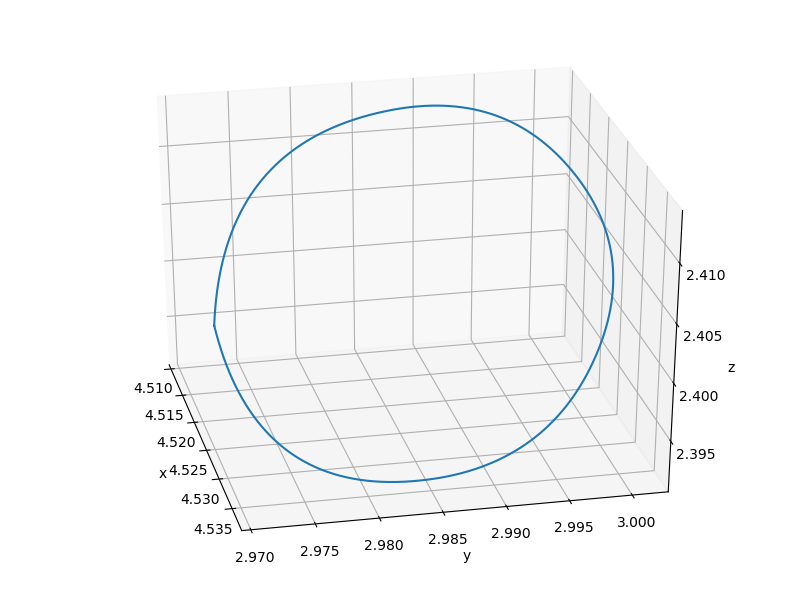

In [103]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

s = np.linspace(0,1,1000)

for l in mf.levelsets[:]:
    #for p in l.points:
    #    ax.scatter(p.pos[0],p.pos[1],p.pos[2])
    #pts = np.array([p.pos for p in l.points])
    pts = np.array([l.interpolation(s0) for s0 in s])
#pts = np.array([scp_splev(s0,l.tck) for s0 in s])
    ax.plot(pts[:,0], pts[:,1], pts[:,2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(0,2*np.pi)
#ax.set_ylim(0,2*np.pi)
#ax.set_zlim(0,2*np.pi)

plt.tight_layout()

In [87]:
mf.levelsets[0].interpolation.s[2]

1.0

In [63]:
np.sum([l.dist for l in mf.levelsets])

2.0800000000000005

In [140]:
mf.levelsets[1].points

IndexError: list index out of range

In [ ]:
self.interpolation = NDCurveBSplineInterpolator(np.asarray([[point.pos[i] for i in range(3)] for point in self.points]))

In [91]:
np.asarray([[point.pos[i] for i in range(3)] for point in mf.levelsets[0].points]).shape

(6, 3)